In [1]:
import sys, os, ndreg, skimage
import matplotlib.pyplot as plt
from matplotlib import cm
import SimpleITK as sitk
import numpy as np
from intern.remote.boss import BossRemote
from intern.resource.boss.resource import *
import missing_data as mdmask
import ingest_tif_stack as ingest

In [2]:
import registerer_copy as reg
import preprocessor_copy as pre
import matplotlib
matplotlib.rcParams['figure.figsize'] = (10.0, 8.0)

In [3]:
atlas = ndreg.imgRead('./atlas/ara_atlas.img')
# atlas_width, atlas_height, atlas_depth = atlas.GetSize()

In [4]:
full_img = ndreg.imgRead('./missing_insula/whole_insula.img')
# Reorient image to be same orientation as atlas
orientation_atlas = 'pir'
orientation_image = 'lps'
full_img = ndreg.imgReorient(full_img, orientation_image, orientation_atlas)
# img_width, img_height, img_depth = full_img.GetSize()

In [5]:
def run_experiment(atlas, img, missing_percentages, missing_dim):
    atlas_width, atlas_height, atlas_depth = atlas.GetSize()
    img_width, img_height, img_depth = full_img.GetSize()
    
    percent_results = {}
    
    for p in missing_percentages:

        # Create the missing image
        missing_array = mdmask.gen_frac_mask(img_depth, img_height, img_width, p, missing_dim, side='right')
        missing_mask = mdmask.convert_to_image(missing_array.astype('uint16'))
        missing_mask.CopyInformation(full_img)
        missing_img = mdmask.mask_img(full_img, missing_mask)

        img = missing_img

        # Bias correction
        mask_dilation_radius = 10 # voxels
        mask_bc = sitk.BinaryDilate(pre.create_mask(img, use_triangle=True), mask_dilation_radius)
        img_bc, bias = pre.correct_bias_field(img, scale=0.25, spline_order=4, mask=mask_bc,
                                             num_control_pts=[5,5,5],
                                             niters=[50, 50, 50, 50])
        atlas_n = sitk.Normalize(atlas)
        img_bc_n = sitk.Normalize(img_bc)

        # Compute affine transform
        final_transform = reg.register_affine(atlas_n,
                                            img_bc_n,
#                                             fixed_mask=missing_mask,
                                            learning_rate=1e-1,
                                            grad_tol=4e-6,
                                            use_mi=False,
                                            iters=50,
                                            shrink_factors=[4,2,1],
                                            sigmas=[0.4, 0.2, 0.1],
                                            verbose=False)

        # Perform the rigid transform
        atlas_rigid = reg.resample(atlas, final_transform, img_bc, default_value=ndreg.imgPercentile(atlas,0.01))

        print("Percentage of image mssing: {}".format(p))
        ndreg.imgShow(atlas_rigid)
        percent_results[p] = (atlas_rigid, final_transform, img)
    return percent_results

# Affine experiments

1. Try increasing missing data amount until rigid doesn't work
2. Try composing translation then rotation transforms
3. Look into the versor transform, registration method functions
 * http://insightsoftwareconsortium.github.io/SimpleITK-Notebooks/Python_html/22_Transforms.html
4. Try take out the physical optimizer
5. Look at the transformation computed

In [6]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual,FloatSlider
import ipywidgets as widgets

def atlas_rigid_slider(x, res):
    plt.clf()
    atlas_rigid, final_transform, img = res[x]
    ndreg.imgShow(atlas_rigid)
    return

def mse_plot_slider(x, res):
    plt.clf()
    atlas_rigid, final_transform, img = res[x]
    mask_dilation_radius = 10 # voxels
    mask_bc = sitk.BinaryDilate(pre.create_mask(img, use_triangle=True), mask_dilation_radius)
    atlas_rigid_slice = sitk.GetArrayFromImage(sitk.Normalize(atlas_rigid))[:,50,:]
    img_rigid_slice = sitk.GetArrayFromImage(sitk.Normalize(img))[:,50,:]
    side_img_slice = sitk.GetArrayFromImage(mask_bc)[:,50,:]
    mdmask.plot_mse(atlas_rigid_slice, img_rigid_slice, side_img=side_img_slice, color_blend=True)
    return

def missing_img_slider(x, res):
    plt.clf()
    atlas_rigid, final_transform, img = res[x]
    ndreg.imgShow(img, vmax=2500)
    return

## Anterior missing

In [7]:
starting_percent = 0.0; ending_percent = 0.50; increments = 25
missing_percentages = np.round(np.linspace(starting_percent, ending_percent, 
                                           num=int(increments*(ending_percent-starting_percent))+1), 2)
missing_dim = 2
print("Missing percentages: {}".format(list(missing_percentages)))

Missing percentages: [0.0, 0.04, 0.08, 0.12, 0.17, 0.21, 0.25, 0.29, 0.33, 0.38, 0.42, 0.46, 0.5]


Percentage of image mssing: 0.0


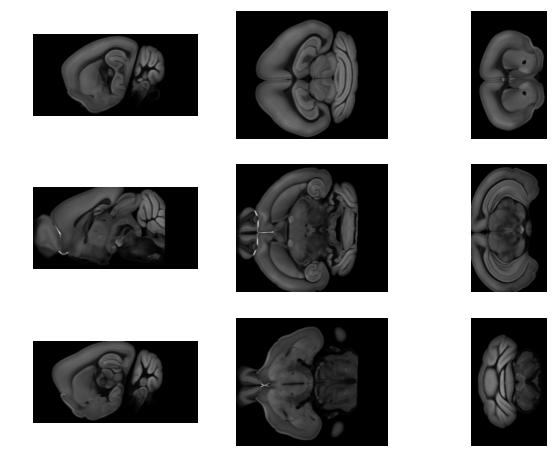

Percentage of image mssing: 0.04


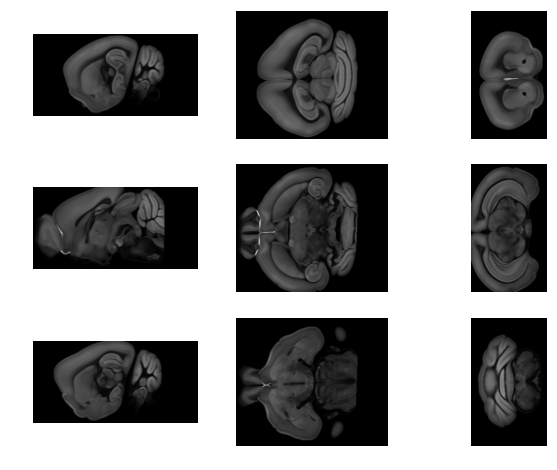

Percentage of image mssing: 0.08


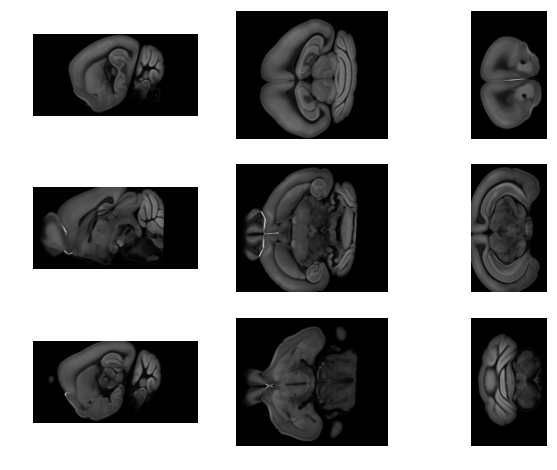

Percentage of image mssing: 0.12


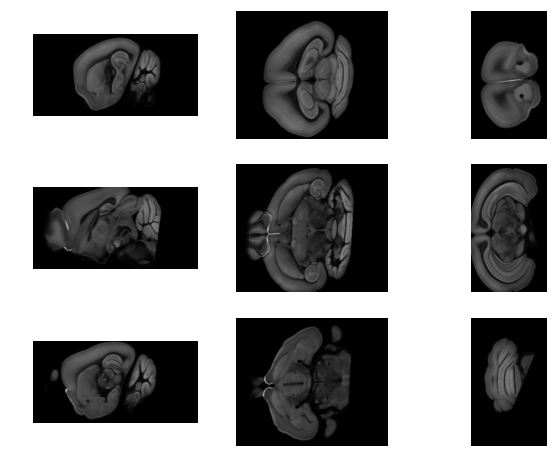

Percentage of image mssing: 0.17


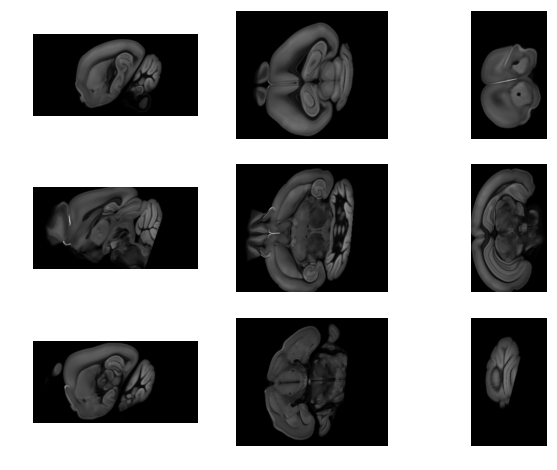

Percentage of image mssing: 0.21


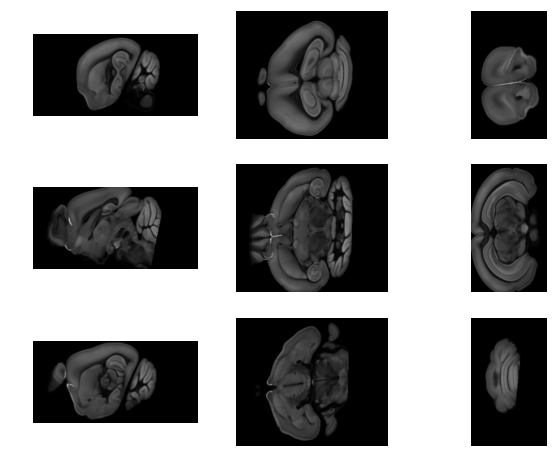

Percentage of image mssing: 0.25


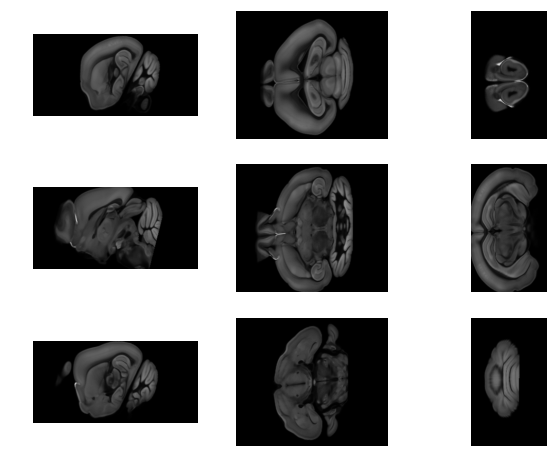

Percentage of image mssing: 0.29


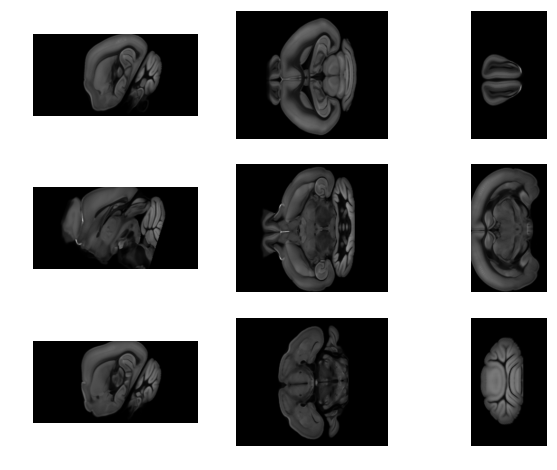

Percentage of image mssing: 0.33


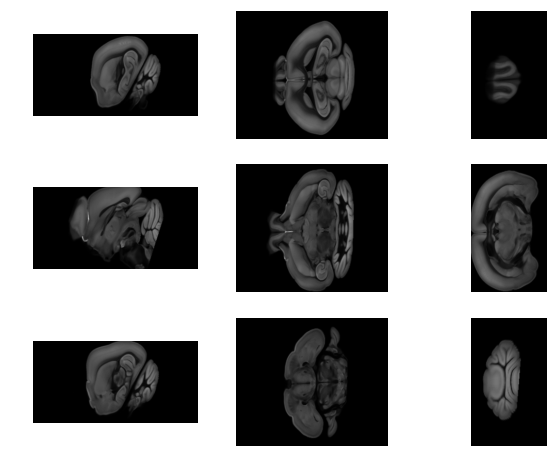

Percentage of image mssing: 0.38


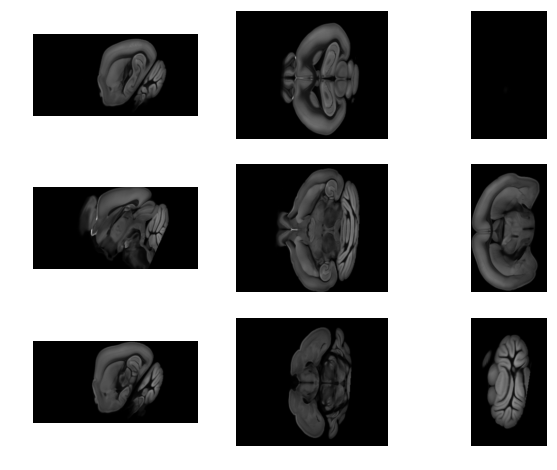

Percentage of image mssing: 0.42


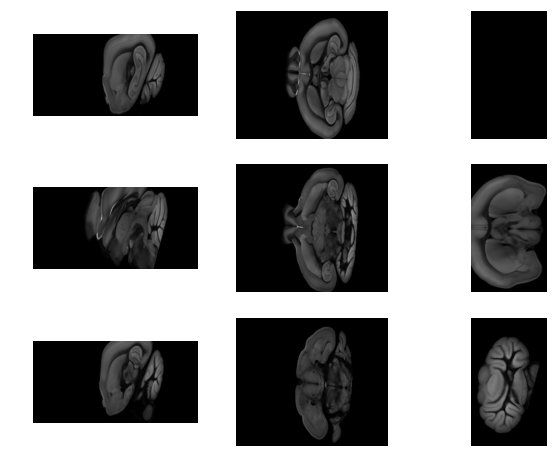

Percentage of image mssing: 0.46


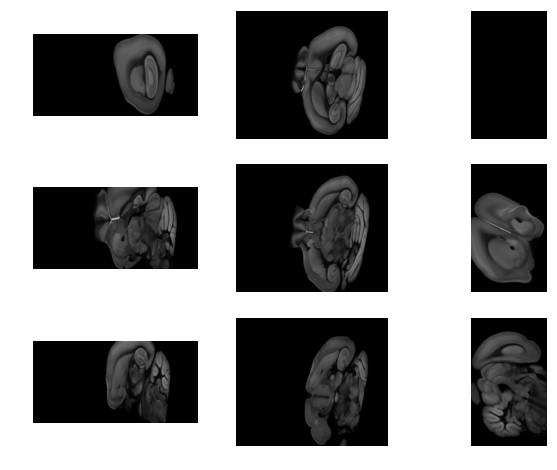

Percentage of image mssing: 0.5


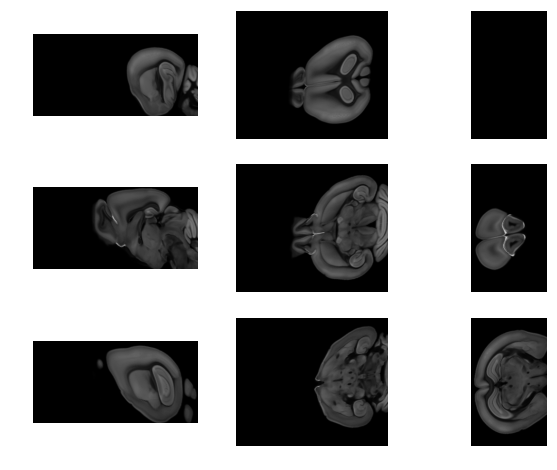

In [8]:
ant_percent_results = run_experiment(atlas, full_img, missing_percentages, missing_dim)

In [9]:
interact(mse_plot_slider, 
         res=fixed(ant_percent_results),
         x=FloatSlider(min=starting_percent, max=ending_percent+0.0001, step=1/float(increments), continuous_update=False))


interactive(children=(FloatSlider(value=0.0, continuous_update=False, description=u'x', max=0.5001, step=0.04), Output()), _dom_classes=('widget-interact',))

<function __main__.mse_plot_slider>

In [10]:
interact(atlas_rigid_slider, 
         res=fixed(ant_percent_results),
         x=FloatSlider(min=starting_percent, max=ending_percent+0.0001, step=1/float(increments), continuous_update=True))


interactive(children=(FloatSlider(value=0.0, description=u'x', max=0.5001, step=0.04), Output()), _dom_classes=('widget-interact',))

<function __main__.atlas_rigid_slider>

In [11]:
interact(missing_img_slider, 
         res=fixed(ant_percent_results),
         x=FloatSlider(min=starting_percent, max=ending_percent+0.0001, step=1/float(increments), continuous_update=True))


interactive(children=(FloatSlider(value=0.0, description=u'x', max=0.5001, step=0.04), Output()), _dom_classes=('widget-interact',))

<function __main__.missing_img_slider>

## Hemisphere missing

In [12]:
starting_percent = 0.0; ending_percent = 0.40; increment_factor = 20
missing_percentages = np.round(np.linspace(starting_percent, ending_percent, 
                                           num=int(increments*(ending_percent-starting_percent))+1), 2)
missing_dim = 0
print("Missing percentages: {}".format(list(missing_percentages)))

Missing percentages: [0.0, 0.04, 0.08, 0.12, 0.16, 0.2, 0.24, 0.28, 0.32, 0.36, 0.4]


Percentage of image mssing: 0.0


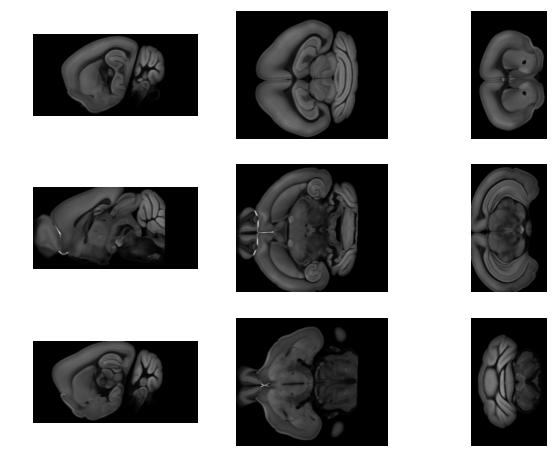

Percentage of image mssing: 0.04


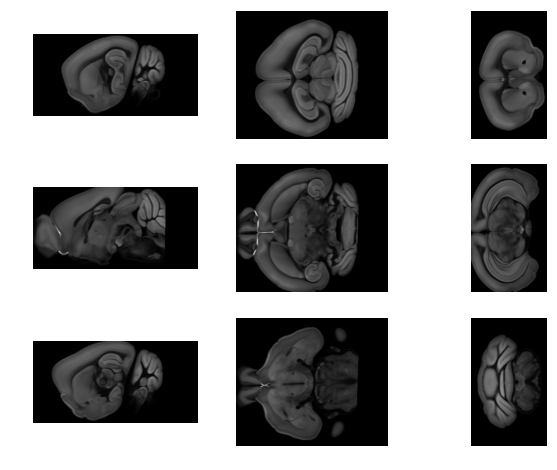

Percentage of image mssing: 0.08


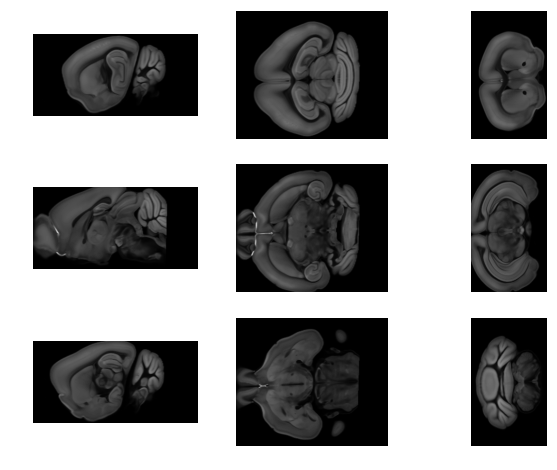

Percentage of image mssing: 0.12


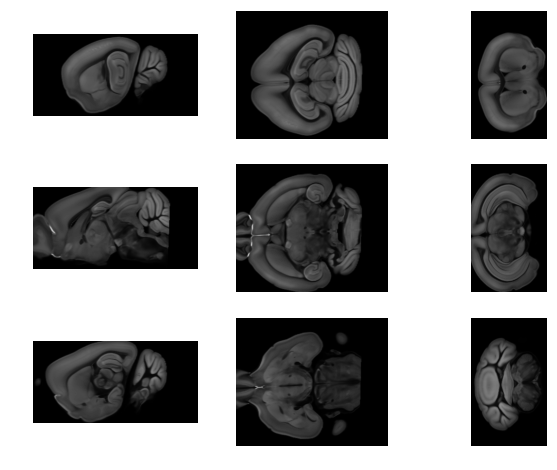

Percentage of image mssing: 0.16


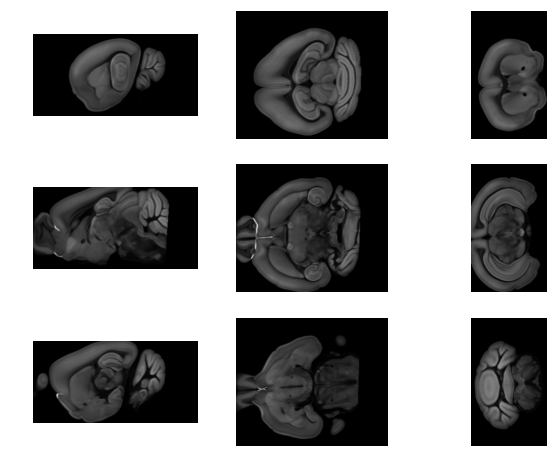

Percentage of image mssing: 0.2


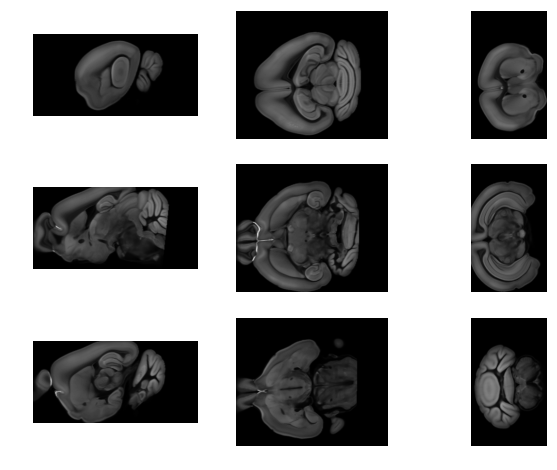

Percentage of image mssing: 0.24


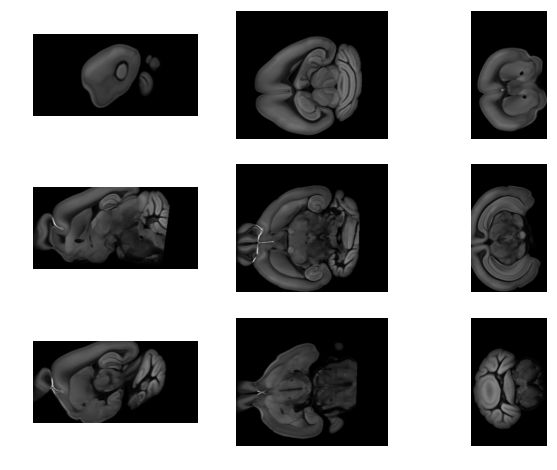

Percentage of image mssing: 0.28


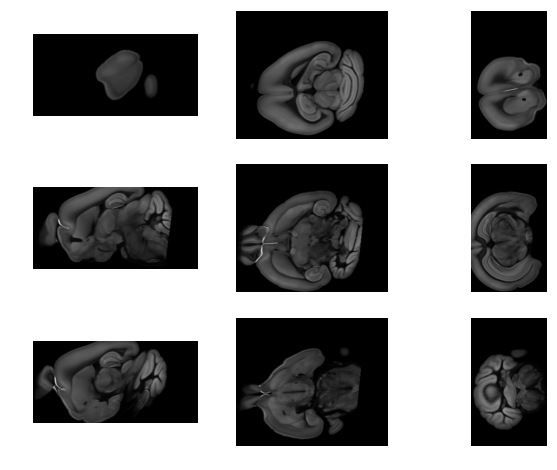

Percentage of image mssing: 0.32


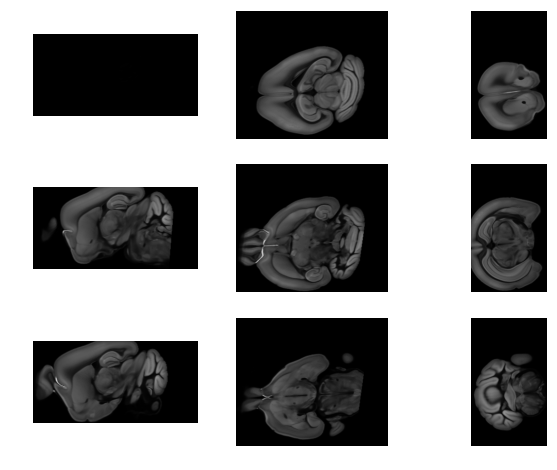

Percentage of image mssing: 0.36


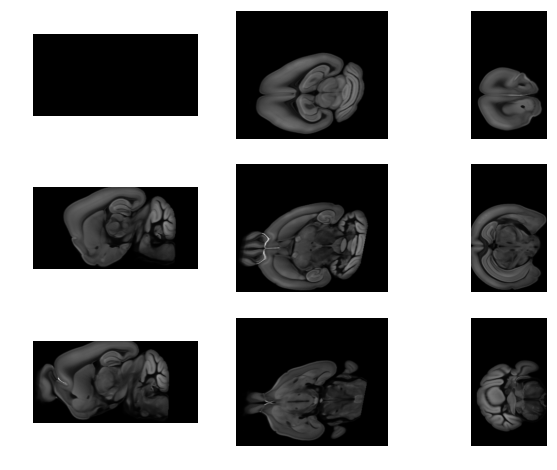

Percentage of image mssing: 0.4


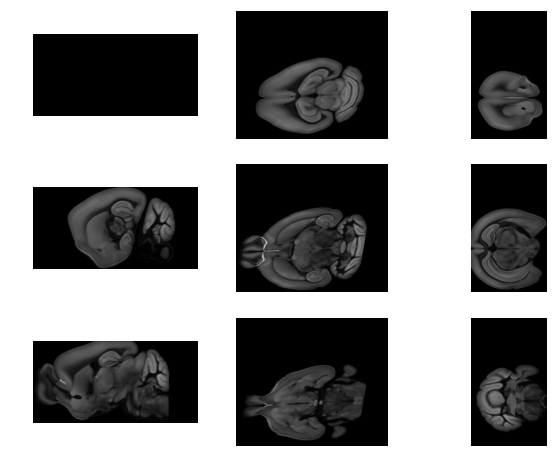

In [13]:
hemi_percent_results = run_experiment(atlas, full_img, missing_percentages, missing_dim)

In [14]:
interact(mse_plot_slider, 
         res=fixed(hemi_percent_results),
         x=FloatSlider(min=starting_percent, max=ending_percent+0.0001, step=1/float(increments), continuous_update=True))


interactive(children=(FloatSlider(value=0.0, description=u'x', max=0.4001, step=0.04), Output()), _dom_classes=('widget-interact',))

<function __main__.mse_plot_slider>

In [15]:
interact(atlas_rigid_slider, 
         res=fixed(hemi_percent_results),
         x=FloatSlider(min=starting_percent, max=ending_percent+0.0001, step=1/float(increments), continuous_update=False))


interactive(children=(FloatSlider(value=0.0, continuous_update=False, description=u'x', max=0.4001, step=0.04), Output()), _dom_classes=('widget-interact',))

<function __main__.atlas_rigid_slider>

In [16]:
interact(missing_img_slider, 
         res=fixed(hemi_percent_results),
         x=FloatSlider(min=starting_percent, max=ending_percent+0.0001, step=1/float(increments), continuous_update=False))


interactive(children=(FloatSlider(value=0.0, continuous_update=False, description=u'x', max=0.4001, step=0.04), Output()), _dom_classes=('widget-interact',))

<function __main__.missing_img_slider>

# Create gifs

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

In [18]:
def atlas_rigid_update(x):
    plt.clf()
    atlas_rigid, final_transform, img = result_dict[x]
    ndreg.imgShow(atlas_rigid)
    return

def mse_anim_update(x):
    atlas_rigid, final_transform, img = result_dict[x]
    mask_dilation_radius = 10 # voxels
    mask_bc = sitk.BinaryDilate(pre.create_mask(img, use_triangle=True), mask_dilation_radius)
    atlas_rigid_slice = sitk.GetArrayFromImage(sitk.Normalize(atlas_rigid))[:,50,:]
    img_rigid_slice = sitk.GetArrayFromImage(sitk.Normalize(img))[:,50,:]
    side_img_slice = sitk.GetArrayFromImage(mask_bc)[:,50,:]
    mdmask.plot_mse(atlas_rigid_slice, img_rigid_slice, side_img=side_img_slice, color_blend=True)
    return

def missing_img_update(x):
    atlas_rigid, final_transform, img = result_dict[x]
    ndreg.imgShow(img, vmax=2500)
    return

## Missing Hemisphere

In [19]:
anim_fargs = np.round(np.linspace(starting_percent, ending_percent, 10),2)
result_dict = hemi_percent_results

missing_data.py:37: RuntimeWarning: divide by zero encountered in log
  y_errors = np.log(np.array(y_errors))


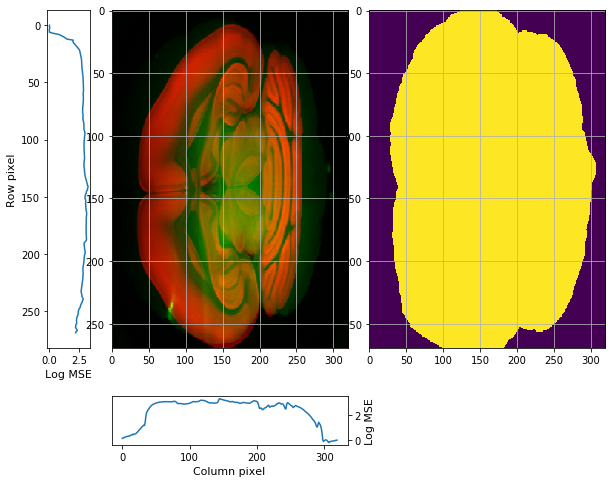

In [20]:
mse_plot_anim = animation.FuncAnimation(plt.figure(), mse_anim_update, frames=missing_percentages,interval=200)
mse_plot_anim.save('mse_anim_affine_hemi_no_mask.mp4')

In [21]:
# mse_plot_anim = animation.FuncAnimation(plt.figure(), atlas_rigid_update, frames=anim_fargs,interval=200)
# mse_plot_anim.save('atlas_rigid_hemi.mp4')

In [22]:
# mse_plot_anim = animation.FuncAnimation(plt.figure(), missing_img_update, frames=anim_fargs,interval=200)
# mse_plot_anim.save('missing_img_hemi.mp4')

## Missing Anterior

In [30]:
anim_fargs

array([0.  , 0.04, 0.09, 0.13, 0.18, 0.22, 0.27, 0.31, 0.36, 0.4 ])

In [29]:
sorted([int(x) for x in ant_percent_results.keys()])

[0.0, 0.04, 0.08, 0.12, 0.17, 0.21, 0.25, 0.29, 0.33, 0.38, 0.42, 0.46, 0.5]

In [25]:
anim_fargs = np.round(np.linspace(starting_percent, ending_percent, 10),2)
result_dict = ant_percent_results

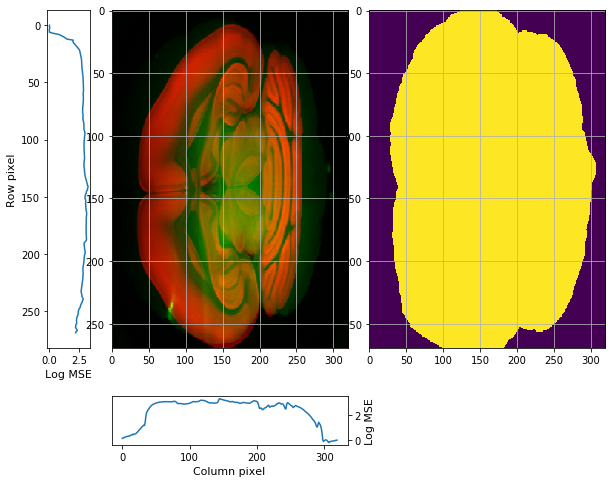

In [31]:
mse_plot_anim = animation.FuncAnimation(plt.figure(), mse_anim_update, frames=sorted(ant_percent_results.keys()),interval=200)
mse_plot_anim.save('mse_anim_affine_ant_no_mask.mp4')

In [ ]:
# mse_plot_anim = animation.FuncAnimation(plt.figure(), atlas_rigid_update, frames=anim_fargs,interval=200)
# mse_plot_anim.save('atlas_rigid_hemi.mp4')

In [ ]:
# mse_plot_anim = animation.FuncAnimation(plt.figure(), missing_img_update, frames=anim_fargs,interval=200)
# mse_plot_anim.save('missing_img_hemi.mp4')